Author: Gregor Kobsik

Date: 15.12.2020

Description: This notebook shows a basic implementation of a transformer (decoder) architecture for image generation in TensorFlow 2.

References:

[Transformers Tutorial](https://www.tensorflow.org/tutorials/text/transformer) - This notebook is based on this tutorial.

[Illustrated Transformers Guide](http://jalammar.github.io/illustrated-transformer/) - Quick visuall explanation.

[ImageGPT in PyTorch](https://github.com/teddykoker/image-gpt) - Other reference implementation in PyTorch.


# Transformer Decoder for Images aka ImageGPT

In [1]:
import tensorflow as tf
# https://stackoverflow.com/a/60699372/7989988
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

import tensorflow_datasets as tfds

import time
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from sklearn.cluster import MiniBatchKMeans

## Setup input pipeline

### Download data

This dataset contains 60000 training examples. [MNIST](https://www.tensorflow.org/datasets/catalog/mnist)-Reference.

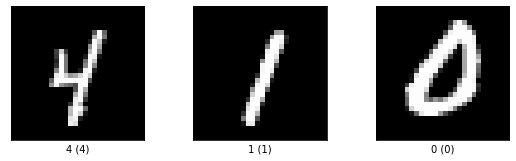

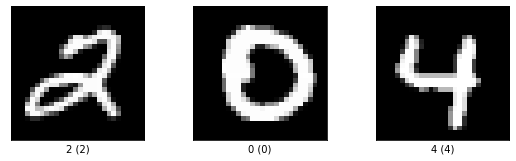

In [2]:
DATASET = 'mnist'
image_width = 28
image_height = 28

examples, metadata = tfds.load(DATASET, with_info=True, as_supervised=True)

train_examples = examples['train']
val_examples = examples['test']

fig = tfds.show_examples(train_examples.take(3), metadata)
fig = tfds.show_examples(val_examples.take(3), metadata)

### Compute centroids
Perform K-Means clustering to find `k` cluster centers of the given images/pixels. 

First map pixel values to a range `[0, 1]`.

In [3]:
NUM_CLUSTERS = 8

def normalize_image(image, label):
    return tf.cast(image, dtype=tf.float16) / 255.0, label

def find_centroids(ds_train, num_clusters=16, batch_size=1024):
    kmeans = MiniBatchKMeans(n_clusters=num_clusters, random_state=0, batch_size=batch_size, verbose=True)
    ds_batched = ds_train.batch(batch_size)
    for img, _ in tqdm(iter(ds_batched)):
        pixels = img.numpy().reshape(-1, img.shape[-1])
        kmeans.partial_fit(pixels)

    return kmeans.cluster_centers_

centroids = find_centroids(train_examples.map(normalize_image), NUM_CLUSTERS, NUM_CLUSTERS*4)
centroids = tf.convert_to_tensor(centroids, dtype=tf.float16)
print(centroids.shape)


(8, 1)


### Quantize images

Quantize all samples to create a training dataset.

- First, flatten each input batch.
- Next, compute the euclidean distance to the centroid for each pixel.
- Last, take the index with the smallest distance as the resulting label.

The size of the tensor shape is given in brackets.

In [4]:
def squared_euclidean_distance(a, b):
    b = tf.transpose(b)        
    a2 = tf.math.reduce_sum(tf.math.square(a), axis=1, keepdims=True)
    b2 = tf.math.reduce_sum(tf.math.square(b), axis=0, keepdims=True)
    ab = tf.linalg.matmul(a, b)
    return a2 - 2 * ab + b2

def quantize(image, label):
    shape = tf.shape(image) # (height, width, color)
    x = tf.reshape(image, (-1, shape[2])) # (height * width, color)
    d = squared_euclidean_distance(x, centroids) # (height * width, centroids)
    sequence = tf.math.argmin(d, axis=1)  # (height * width)
    return sequence, label

In [5]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BUFFER_SIZE = 1000
BATCH_SIZE = 16

train_dataset = (
    train_examples
    .map(normalize_image)
    .map(quantize)
    .cache()
    .shuffle(BUFFER_SIZE)
    .padded_batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)
val_dataset = (
    val_examples
    .map(normalize_image)
    .map(quantize)
    .cache()
    .padded_batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

Inspect a random data sequence sample.

In [6]:
NUM_SAMPLES = 1

image_batch, _ = next(iter(train_dataset))
print(image_batch[:NUM_SAMPLES])

tf.Tensor(
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 1 1 7 0 0 0 0 0 0 0 0 0 2
  1 3 0 0 0 0 0 0 0 0 0 0 0 0 4 1 1 7 0 0 0 0 0 0 0 0 0 7 1 1 0 0 0 0 0 0
  0 0 0 0 0 0 3 1 1 3 0 0 0 0 0 0 0 0 5 1 1 2 0 0 0 0 0 0 0 0 0 0 0 5 1 1
  7 4 0 0 0 0 0 0 0 0 5 1 1 2 0 0 0 0 0 0 0 0 0 0 0 7 1 1 5 0 0 0 0 0 0 0
  0 0 5 1 1 4 0 0 0 0 0 0 0 0 0 0 2 1 1 3 4 0 0 0 0 0 0 0 0 0 3 1 1 4 0 0
  0 0 0 0 0 0 0 0 1 1 1 2 4 4 4 4 0 0 0 0 0 0 7 1 3 0 0 4 0 0 0 0 0 0 0 0
  1 1 1 1 1 1 7 3 3 3 6 5 3 2 1 1 7 3 3 7 0 0 0 0 0 0 0 0 7 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 4 2 4 5 3 3 6 5 3 3 3 3 3 1 1 1
  1 1 1 3 0 0 0 0 0 0 0 0 0

And now show some quantitized and unquantized images. 

First, define a function to revert the quantization.

In [7]:
def unquantize(x):
    x_one_hot = tf.cast(tf.one_hot(x, depth=len(centroids)), dtype=tf.float16)  # (seq, num_centroids)
    return tf.linalg.matmul(x_one_hot,centroids)  # (seq, num_features)

def np_showSeq(seq, size, max_images=3, cmap=None):
    """ Show one or more images encoded as sequence. (numpy version)

        seq: numpy array of sequences which encode the image. Either a single sequence or multiple sequences.
        size: the image size. e.g. (28, 28) for `mnist` images.
        max_images: the maximum number of images to display.
    """ 
    batch = seq.shape[0]
    num_show_img = min(max_images, seq.shape[0])
    img = np.reshape(seq, (batch, *size, -1))
    if img.shape[-1] == 1:
      img = np.squeeze(img, axis=-1)    
    
    fig=plt.figure(figsize=(3*num_show_img, 3))
    for i in range(num_show_img):
        ax = fig.add_subplot(1, num_show_img, i+1)
        ax.set_axis_off()
        plt.imshow(img[i], cmap=cmap)
    plt.show()

def showSeq(seq, size, max_images=3, cmap=None):
    """ Show one or more images encoded as sequence. (tensorflow version)

        seq: tensor of sequences which encode the image. Either a single sequence or multiple sequences.
        size: the image size. e.g. (28, 28) for `mnist` images.
        max_images: the maximum number of images to display.
    """
    if cmap:
        seq = tf.map_fn(fn=unquantize, elems=seq, fn_output_signature=tf.float16)
    seq = tf.cast(seq, float).numpy()

    np_showSeq(seq, size, max_images, cmap)

quantized:


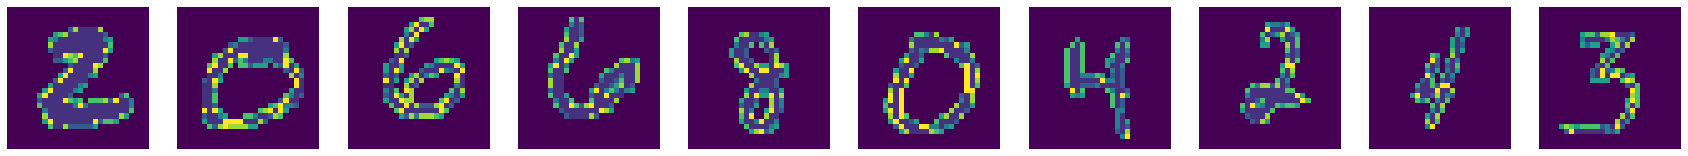

unquantized


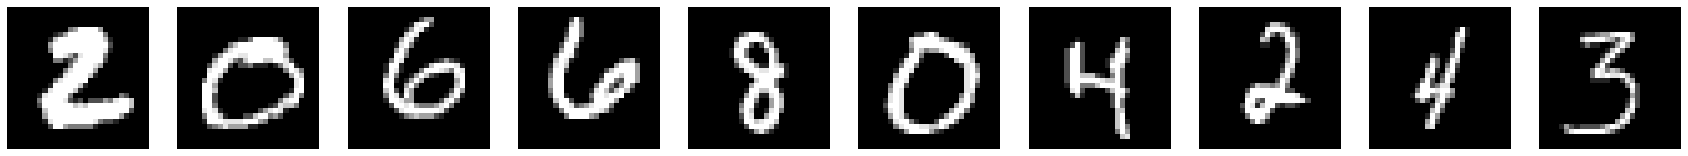

In [34]:
NUM_SAMPLES = 10

image_batch, _ = next(iter(train_dataset))
image_batch = image_batch[:NUM_SAMPLES]

print("quantized:")
showSeq(image_batch, (image_width, image_height), NUM_SAMPLES)
print("unquantized")
showSeq(image_batch, (image_width, image_height), NUM_SAMPLES, cmap='gray')

## Masking

The look-ahead mask is used to mask the future tokens in a sequence. In other words, the mask indicates which entries should not be used.

e.g. If we predict the third token, we use only the first and second token as reference. 
All future tokens will be masked in the seöf-attention by subtracting a very big number from the corresponding attention logits.

In [9]:
def create_look_ahead_mask(size_q, size_k):
  mask = 1 - tf.linalg.band_part(tf.ones((size_q, size_k)), -1, 0)
  return mask  # (seq_len, seq_len)

In [10]:
print(create_look_ahead_mask(5, 5))

tf.Tensor(
[[0. 1. 1. 1. 1.]
 [0. 0. 1. 1. 1.]
 [0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0.]], shape=(5, 5), dtype=float32)


## Scaled dot product attention

The attention function used by the transformer takes three inputs: Q (query), K (key), V (value). The equation used to calculate the attention weights is:

$$\Large{Attention(Q, K, V) = softmax_k(\frac{QK^T}{\sqrt{d_k}}) V} $$

We call the function Self-Attention if we use the same input for Q, K and V.

The mask is applied by multiplying it with -1e9 (close to negative infinity) and subtracting it from the attention logits. The following softmax function will render the corresponding positions to zero or almost zero and thus ignore them.

In [11]:
def scaled_dot_product_attention(q, k, v, mask):
  """Calculate the attention weights.
  q, k, v must have matching leading dimensions.
  k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
  The mask has different shapes depending on its type(padding or look ahead) 
  but it must be broadcastable for addition.
  
  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Any value to create and use a lookahead mask. 
          Defaults to None.
    
  Returns:
    output, attention_weights
  """

  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
  
  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
  if mask is not None:
    mask = create_look_ahead_mask(tf.shape(q)[-2], tf.shape(k)[-2])
    scaled_attention_logits += (mask * -1e9)  

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

In [12]:
temp_x = tf.constant([[10,0,0],
                      [0,10,0],
                      [0,0,10]], dtype=tf.float32)  # (3, 3)
temp_mask = create_look_ahead_mask(3, 3)

temp_out, temp_attn = scaled_dot_product_attention(
      temp_x, temp_x, temp_x, temp_mask)
print ('Attention weights are:')
print (temp_attn)
print ('Output is:')
print (temp_out)

Attention weights are:
tf.Tensor(
[[1.000000e+00 0.000000e+00 0.000000e+00]
 [8.433274e-26 1.000000e+00 0.000000e+00]
 [8.433274e-26 8.433274e-26 1.000000e+00]], shape=(3, 3), dtype=float32)
Output is:
tf.Tensor(
[[1.000000e+01 0.000000e+00 0.000000e+00]
 [8.433274e-25 1.000000e+01 0.000000e+00]
 [8.433274e-25 8.433274e-25 1.000000e+01]], shape=(3, 3), dtype=float32)


## Multi-head attention

Multi-head attention consists of four parts:
*    Linear layers and split into heads.
*    Scaled dot-product attention.
*    Concatenation of heads.
*    Final linear layer.

Each multi-head attention block gets three inputs; Q (query), K (key), V (value). These are put through linear (Dense) layers and split up into multiple heads.

The `scaled_dot_product_attention` defined above is applied to each head (broadcasted for efficiency). An appropriate mask must be used in the attention step.  The attention output for each head is then concatenated (using `tf.transpose`, and `tf.reshape`) and put through a final `Dense` layer.

TODO: Use directly [MultiHeadAttention](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MultiHeadAttention)

In [13]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model
    
    assert d_model % self.num_heads == 0
    
    self.depth = d_model // self.num_heads
    
    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)
    
    self.dense = tf.keras.layers.Dense(d_model)
        
  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])
    
  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]
    
    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)
    
    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)
    
    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)
    
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention, 
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
        
    return output, attention_weights

In [14]:
temp_mha = MultiHeadAttention(d_model=64, num_heads=8)
y = tf.random.uniform((32, 50, 64))  # (batch_size, encoder_sequence, d_model)
out, attn = temp_mha(y, k=y, q=y, mask=None)
out.shape, attn.shape

(TensorShape([32, 50, 64]), TensorShape([32, 8, 50, 50]))

## Point wise feed forward network

Point wise feed forward network consists of two fully-connected layers with a ReLU activation in between.

`TODO`: Use gelu activation function instead of relu.

In [15]:
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      # tf.keras.activations.gelu(approximate=False), # tf-nightly
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

## Decoder

### Decoder Layer

Each `DecoderLayer` consists of sublayers:

-   Multi-head attention (with masking) 
-   Point wise feed forward networks. 

Each of these sublayers has a residual connection around it preceeded by a layer normalization and dropout. Residual connections help in avoiding the vanishing gradient problem in deep networks.

In [16]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    
  def call(self, x, training, mask):
    # t.shape == (batch_size, input_seq_len, d_model) 
    # for t in [x, out1, attn_out, res1, out2, ffn_out, res2]
    
    # masked multihead self-attention with residual connection
    out1 = self.layernorm1(self.dropout1(x, training=training)) 
    attn_out, attn_weights = self.mha(out1, out1, out1, mask) 
    res1 = x + attn_out

    # feed forward neural network with residual connection
    out2 = self.layernorm2(self.dropout2(res1, training=training))
    ffn_out = self.ffn(out2)
    res2 = res1 + ffn_out
    
    return res2, attn_weights

### Decoder Block

The `Decoder` consists of:
-   Input Embedding
-   Positional Embedding
-   N Decoder Layers

The input is put through an token embedding which is summed with the positional embedding. 
The position of each token is simply encoded by their embedded position number, e.g. (0, 1, 2, 3, ...)

The output of this summation is the input to the decoder layers. Afterwards the output is put through a dropout and normalization layer.

In [17]:
class DecoderBlock(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, vocab_size,
               maximum_position_encoding, rate=0.1):
    super(DecoderBlock, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.tok_embedding = tf.keras.layers.Embedding(vocab_size, d_model)
    self.pos_embedding = tf.keras.layers.Embedding(maximum_position_encoding, d_model)                                            
        
    self.enc_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
  
    self.dropout = tf.keras.layers.Dropout(rate)
    self.layer_norm = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
  def call(self, x, training, mask):

    batch = tf.shape(x)[0]
    seq_len = tf.shape(x)[1]
    attention_weights = {}  

    # token and positional embedding
    positions = tf.expand_dims(tf.range(seq_len), axis=0)
    x = self.tok_embedding(x)  # (batch_size, input_seq_len, d_model)
    x = x + tf.tile(self.pos_embedding(positions), [batch, 1, 1])  # (batch_size, input_seq_len, d_model)
    
    # n * decoder layers
    for i in range(self.num_layers):
      x, attn_w = self.enc_layers[i](x, training, mask)
      attention_weights['decoder_layer{}'.format(i+1)] = attn_w

    # dropout and layer normalization
    x = self.dropout(x, training=training)
    x = self.layer_norm(x)
              
    return x, attention_weights  # (batch_size, input_seq_len, d_model)

In [18]:
sample_encoder = DecoderBlock(num_layers=4, d_model=16, num_heads=2, 
                         dff=64, vocab_size=8,
                         maximum_position_encoding=783)
temp_input = tf.random.uniform((32, 783), dtype=tf.int64, minval=0, maxval=8)

sample_encoder_output, _ = sample_encoder(temp_input, training=False, mask=True)

print (sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)

(32, 783, 16)


## Create the Image Transformer 

The Image Transformer consists of the encoder and a final linear layer. The output of the decoder is the input to the linear layer.

Return the output of the final layer, as well as the attention weights of each Decoder Layer.

In [19]:
class ImageTransformer(tf.keras.Model):
  def __init__(self, num_layers, d_model, num_heads, dff,
               vocab_size, max_pos_encoding, rate=0.1):
    super(ImageTransformer, self).__init__()

    self.decoder = DecoderBlock(num_layers, d_model, num_heads, dff, 
                           vocab_size, max_pos_encoding, rate)

    self.final_layer = tf.keras.layers.Dense(vocab_size)
    
  def call(self, inp, tar, training, mask):

    enc_output, attention_weights = self.decoder(inp, training, mask)  # (batch_size, inp_seq_len, d_model)    
    
    final_output = self.final_layer(enc_output)  # (batch_size, tar_seq_len, target_vocab_size)
    
    return final_output, attention_weights

In [20]:
sample_transformer = ImageTransformer(
    num_layers=2, d_model=16, num_heads=2, dff=64,
    vocab_size=8, max_pos_encoding=784)

temp_input = tf.random.uniform((32, 783), dtype=tf.int64, minval=0, maxval=8)
temp_target = tf.random.uniform((32, 783), dtype=tf.int64, minval=0, maxval=10)

fn_out, _ = sample_transformer(temp_input, temp_target, training=False, mask=None)

fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)

TensorShape([32, 783, 8])

## Set hyperparameters
To keep this example small and relatively fast, the values for *num_layers, d_model, and dff* have been reduced. 

In [21]:
num_layers = 8
d_model = 64
dff = 256
num_heads = 4

vocab_size = len(centroids) # num_centroids
max_sequence_length = image_width * image_height
dropout_rate = 0.1

## Optimizer

Use the Adam optimizer with a custom learning rate scheduler according to the formula in the [paper](https://arxiv.org/abs/1706.03762).

$$\Large{lrate = d_{model}^{-0.5} * min(step{\_}num^{-0.5}, step{\_}num * warmup{\_}steps^{-1.5})}$$


In [22]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=2000):
    super(CustomSchedule, self).__init__()
    
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps
    
  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    
    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [23]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.95, 
                                     epsilon=1e-9)

## Loss and metrics

Since the target sequences are padded, it is important to apply a padding mask when calculating the loss.

In [24]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [25]:
def loss_function(real, pred):
  loss_ = loss_object(real, pred)  
  return tf.reduce_mean(loss_)
train_loss = tf.keras.metrics.Mean(name='train_loss')

## Training and checkpointing

Create a new Image Transformer.

In [26]:
transformer = ImageTransformer(num_layers, d_model, num_heads, dff, vocab_size,
                          max_pos_encoding=max_sequence_length, 
                          rate=dropout_rate)
print(f'num_layers: {num_layers}, d_model: {d_model}, num_heads: {num_heads}, dff: {dff}, vocab_size: {vocab_size}, max_pos_encoding: {max_sequence_length}, rate: {dropout_rate}')

num_layers: 8, d_model: 64, num_heads: 4, dff: 256, vocab_size: 8, max_pos_encoding: 784, rate: 0.1


Create the checkpoint path and the checkpoint manager. This will be used to save checkpoints every `n` epochs.

In [27]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

If a checkpoint exists, restore the latest checkpoint. Skip if you want to retrain the model from the beginning.

In [28]:
if ckpt_manager.latest_checkpoint:
 ckpt.restore(ckpt_manager.latest_checkpoint)
 print ('Latest checkpoint restored!!')

In [29]:
# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None), dtype=tf.int64),
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):  
  # add start of sequence token
  tar_inp = inp[:, :-1]
  tar_real = inp[:, 1:]
  
  with tf.GradientTape() as tape:
    predictions, _ = transformer(tar_inp, tar, 
                                 training=True, 
                                 mask=True)
    loss = loss_function(tar_real, predictions)

  gradients = tape.gradient(loss, transformer.trainable_variables)    
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
  
  train_loss(loss)

In [31]:
EPOCHS = 10

epoch_pb = tqdm(range(EPOCHS), desc=f'Training progress')
for epoch in epoch_pb:  
  train_loss.reset_states()
  
  batch_pb = tqdm(enumerate(train_dataset), desc=f'Epoch {epoch+1}')
  for (batch, (inp, tar)) in batch_pb:
    train_step(inp, tar)
    batch_pb.set_postfix_str(f'Loss: {train_loss.result():.4f}, Learning rate: {optimizer._decayed_lr(tf.float32):.5f}')
      
  if (epoch + 1) % 1 == 0:
    ckpt_save_path = ckpt_manager.save()

## Evaluate
Remove half of the image values and restore them iteratively by the outputs of the image transformer.

In [32]:
eval_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None), dtype=tf.int64),
]

@tf.function(input_signature=eval_step_signature)
def call_transformer(inp, tar):
    return transformer(inp, tar, training=False, mask=True)

def evaluate(inp_sequence):

  # remove half of the input 
  idx = int(inp_sequence.shape[-1] / 2) 
  seq = inp_sequence[:, :idx]

  # create target and transform to batched shape
  target = tf.expand_dims(tf.cast([0], dtype=tf.int64), axis=0)
  target = tf.tile(target, [seq.shape[0], 1])

  for _ in tqdm(range(idx)):
    logits, _ = call_transformer(seq, target)
    # apply softmax on the logits and return the result
    predictions = tf.random.categorical(logits[:, -1], 1, dtype=tf.int64)
    # append prediction
    seq = tf.concat([seq, predictions], axis=-1)

  return seq

def process_batch(inp_sequence):
  showSeq(inp_sequence, (image_width, image_height), inp_sequence.shape[0], cmap='gray')
  result_seq = evaluate(inp_sequence)
  showSeq(result_seq, (image_width, image_height), inp_sequence.shape[0], cmap='gray')

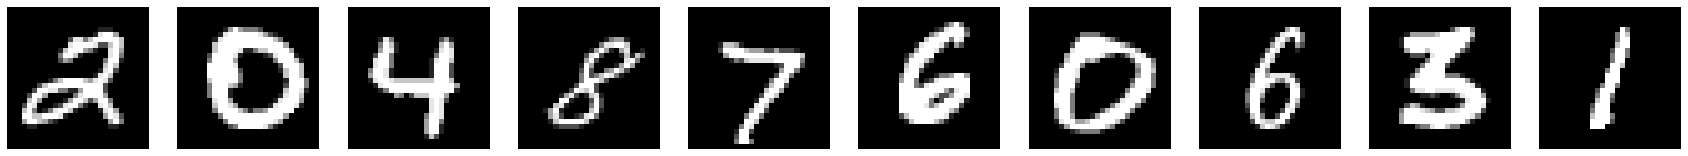

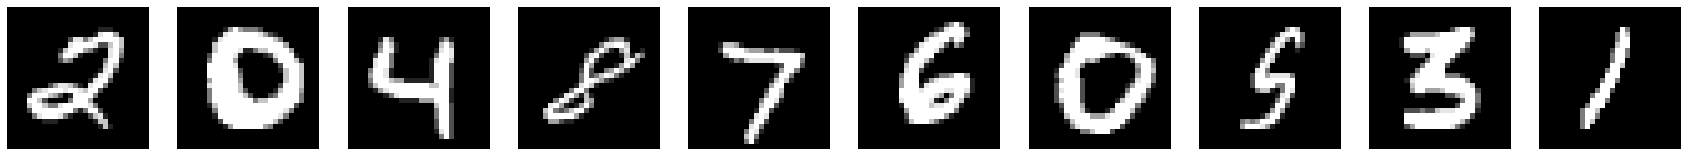

In [33]:
batch = next(iter(val_dataset))
process_batch(batch[0][0:10])

## What's next?

To explore the model further you can examine one of the following points:

- Change the hyperparameters: e.g. the number of layers from 8 to 24 - do not forget to adjust the batch size such that the model still fits into your memory.
- Use a different dataset: e.g. 'cifar10' - do not forget to adjust the image size variables and recompute the centroids, change the centroids size to a bigger number (128).
- Add a classification head: only the generative pretraining is implemented, yet. Add a final dense layer and a classification loss. First run the model with a generative loss only, than run it a second time with a mixed classification and generative loss to classify the inputs.
- Use a different learning rate schedule or activation function: the original ImageGPT paper used a cosine schedule with no dropout and a gelu activation function.

## Further reading

- [Transformers Tutorial](https://www.tensorflow.org/tutorials/text/transformer) - In depth tutorial on transformers in TF2.

- [Illustrated Transformers Guide](http://jalammar.github.io/illustrated-transformer/) - Quick and intuitive explanation of transformers.

- [Image GPT Blog](https://openai.com/blog/image-gpt/) - original ImageGPT by Chen et al.

- [ImageGPT in PyTorch](https://github.com/teddykoker/image-gpt) - an implementation of the code above for PyTorch
